In [1]:
import matplotlib.pyplot as plt
from src.dataset import AFHQDataset

(-0.5, 63.5, 63.5, -0.5)

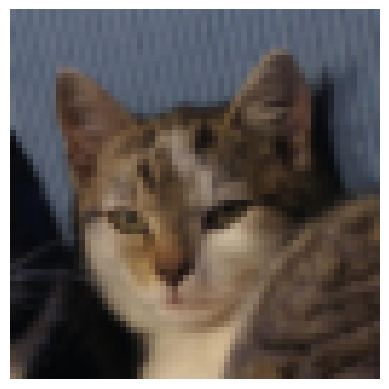

In [19]:
dataset = AFHQDataset(split="cat", train=True, img_size=64)
sample = dataset[4].permute(1, 2, 0)
sample = (sample + 1) / 2
plt.imshow(sample)
plt.axis('off')
